In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pycountry
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import preprocess as pre

In [3]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,6787,palatka,florida,united states,5.0,0-10,0451173139,8,night over water,ken follett,1992,signet book,high
1,102647,modesto,california,united states,14.0,10-20,0451173139,9,night over water,ken follett,1992,signet book,high
2,133682,las cruces,new mexico,united states,15.0,10-20,0451173139,4,night over water,ken follett,1992,signet book,medium
3,114089,pomeroy,ohio,united states,15.0,10-20,0451173139,7,night over water,ken follett,1992,signet book,high
4,23872,tulsa,oklahoma,united states,22.0,20-30,0451173139,8,night over water,ken follett,1992,signet book,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,214212,merlin,oregon,united states,78.0,70-80,0440204275,8,killing time in st. cloud,judith guest,1989,dell publishing company,high
204160,118632,atlanta,georgia,united states,64.0,60-70,0312853807,7,zero coupon,paul erdman,1993,st martins pr,high
204161,160697,erie,pennsylvania,united states,67.0,60-70,0312853807,7,zero coupon,paul erdman,1993,st martins pr,high
204162,14449,saskatoon,saskatchewan,canada,72.0,70-80,0312853807,8,zero coupon,paul erdman,1993,st martins pr,high


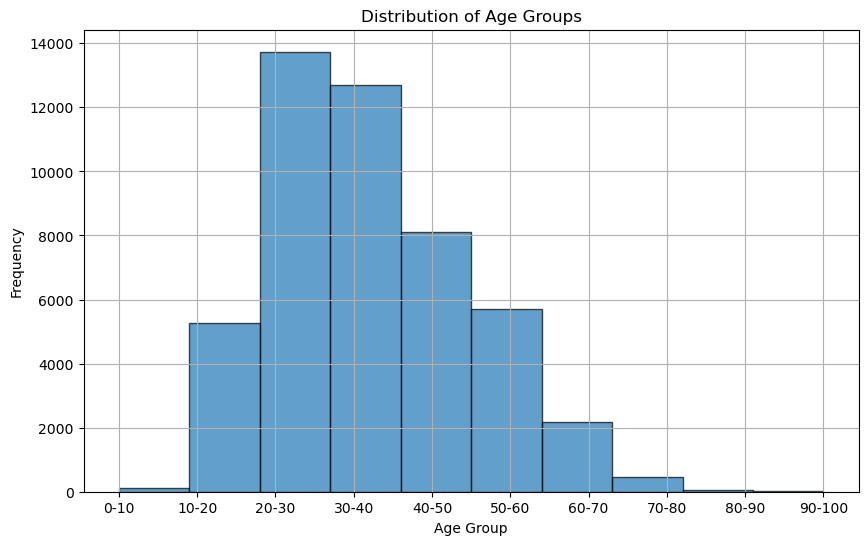

In [4]:
users_df = pd.read_csv(users_file)
ratings_df = pd.read_csv(rating_file)
books_df = pd.read_csv(books_file)

# Imputation missing data and discretise the age based on an age group
users_df = pre.ages_imputation(pre.weighted_age_dict(users_file), users_df)
users_df = pre.city_imputation(users_df)
users_df = pre.state_imputation(users_df)
users_df = pre.country_imputation(users_df)
merged_df = pre.discretising(users_df, ratings_df, books_df)
merged_df = pre.author_imputation(merged_df)
merged_df = pre.text_process(merged_df)
merged_df.to_csv("merge.csv", index=False)

merged_df

Get books names and book ratings

In [5]:
books_rating_df = merged_df[["ISBN", "Book-Title", "Book-Rating"]]
average_ratings = (books_rating_df.groupby(["ISBN", "Book-Title"])["Book-Rating"].mean().reset_index())
books_rating_df = average_ratings.drop_duplicates(subset=["Book-Title"])
rate_bins = [0, 4, 7, 11]
rate_labels = ["low", "medium", "high"]
books_rating_df["Rating_Category"] = pd.cut(
        books_rating_df["Book-Rating"], bins=rate_bins, labels=rate_labels, right=False
    )
books_rating_df

/var/folders/q1/g_n04dv94r3565mj7hw_t4z00000gn/T/ipykernel_9561/4190279325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_rating_df["Rating_Category"] = pd.cut(


,ISBN,Book-Title,Book-Rating,Rating_Category
0,0002005018,clara callan,7.500000,high
1,0002116286,there's a seal in my sleeping bag,7.250000,high
2,0002243962,girlfriend in a coma,5.750000,medium
3,0002251760,the forgetting room: a fiction (byzantium book),8.833333,high
4,0002255081,spadework,6.250000,medium
...,...,...,...,...
18180,9722105248,o evangelho segundo jesus cristo: romance,8.400000,high
18181,9726101794,as mulheres deviam vir com livro de instruãâ§...,6.000000,medium
18182,9728423160,nos teus braãâ§os morrerãâ­amos: ficãâ§ãâ£o,7.000000,high
18183,9812327975,notes from an even smaller island,8.000000,high


# For Test Set

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,261888,gateshead,england,united kingdom,5.0,0-10,0586064540,5,the bourne supremacy,robert ludlum,0,hunter publishing+inc,medium
1,114865,croydon,victoria,australia,97.0,90-100,0586064540,8,the bourne supremacy,robert ludlum,0,hunter publishing+inc,high
2,170699,bellingham,washington,united states,5.0,0-10,0449909433,4,travels with lizbeth: three years on the road ...,lars eighner,1994,ballantine books,medium
3,260678,hooksett,new hampshire,united states,39.0,30-40,0449909433,6,travels with lizbeth: three years on the road ...,lars eighner,1994,ballantine books,medium
4,197688,fiddletown,california,united states,5.0,0-10,068484415X,7,climbing the mountain : my search for meaning,kirk douglas,1997,simon & schuster,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,273190,coconut grove,metro manila,turkey,71.0,70-80,091482967X,7,the blessings already are,john morton,2000,mandeville press,high
23141,261037,manchester,england,united kingdom,75.0,70-80,0851120989,5,guinness book of world records 2000,guinness,1999,guinness world records ltd,medium
23142,88389,severna park,maryland,united states,77.0,70-80,0310405009,6,a rustle of angels: stories about angels in re...,marilynn carlson webber,1994,zondervan,medium
23143,30650,walla walla,västerbotten,austria,78.0,70-80,0310405009,8,a rustle of angels: stories about angels in re...,marilynn carlson webber,1994,zondervan,high


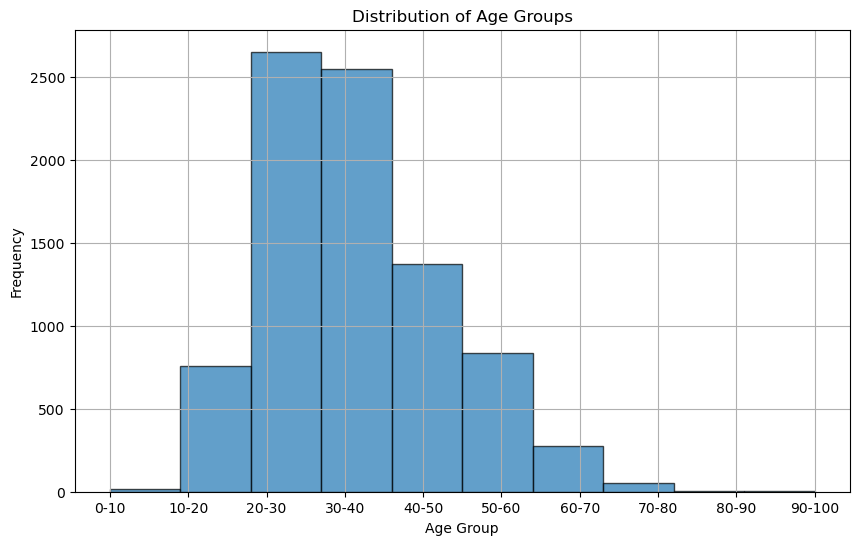

In [6]:
new_users_df = pd.read_csv(new_users_file)
new_ratings_df = pd.read_csv(new_ratings_file)
new_books_df = pd.read_csv(new_books_file)

# Imputation missing data and discretise the age based on an age group
new_users_df = pre.ages_imputation(pre.weighted_age_dict(new_users_file), new_users_df)
new_users_df = pre.city_imputation(new_users_df)
new_users_df = pre.state_imputation(new_users_df)
new_users_df = pre.country_imputation(new_users_df)
test_merged_df = pre.discretising(new_users_df, new_ratings_df, new_books_df)
test_merged_df = pre.author_imputation(test_merged_df)
test_merged_df = pre.text_process(test_merged_df)
test_merged_df

In [7]:
for feature in [
    "User-City",
    "User-State",
    "User-Country",
    "Age-Group",
    "Book-Author",
    "Year-Of-Publication",
    "Book-Publisher",
    "Book-Title"
]:
    print(
        feature,
        pre.compute_information_gain(
            merged_df[feature], merged_df["Rating_Category"]
        ).round(4),
    )

User-City 0.1038
User-State 0.0166
User-Country 0.0021
Age-Group 0.0008
Book-Author 0.0751
Year-Of-Publication 0.0027
Book-Publisher 0.0231
Book-Title 0.1435


In [8]:
# Deleted Features with low IG to train the DT
new_features = [
    "User-City",
    "Book-Author",
    "Book-Title",
]

train_X = OrdinalEncoder().fit_transform(merged_df[new_features])
train_y = OrdinalEncoder().fit_transform(merged_df[["Rating_Category"]])

test_X = OrdinalEncoder().fit_transform(test_merged_df[new_features])
test_y = OrdinalEncoder().fit_transform(test_merged_df[["Rating_Category"]])

# Initialise the DT
dt_classifier = DecisionTreeClassifier(criterion="entropy")

# Train the model
dt_classifier.fit(train_X, train_y)

# Do Cross validation to test the training process
cross_validation = cross_val_score(dt_classifier, train_X, train_y, cv=10)
print("Cross Validation Scores:", cross_validation)
print("Average Score:", np.mean(cross_validation))

pred_y = dt_classifier.predict(test_X)

accuracy = accuracy_score(pred_y, test_y)
print("Final Accuracy:", accuracy)

Cross Validation Scores: [0.66552383 0.59695352 0.56394181 0.61977764 0.63190635 0.63611873
 0.65056818 0.643221   0.6497355  0.65360502]
Average Score: 0.6311351577351254
Final Accuracy: 0.6205659969755887


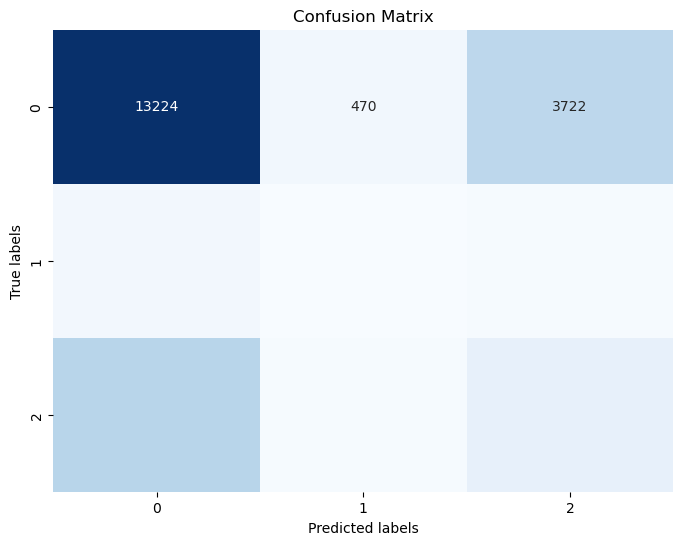

In [9]:
# Confusion matrix
cm = confusion_matrix(test_y, pred_y)

# Visulisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

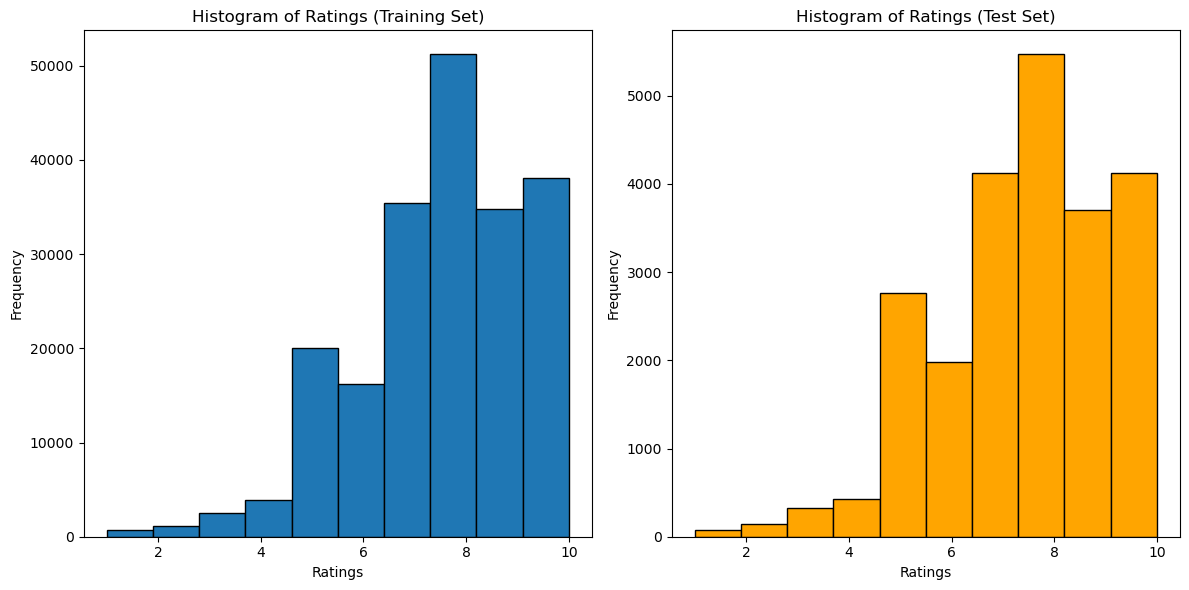

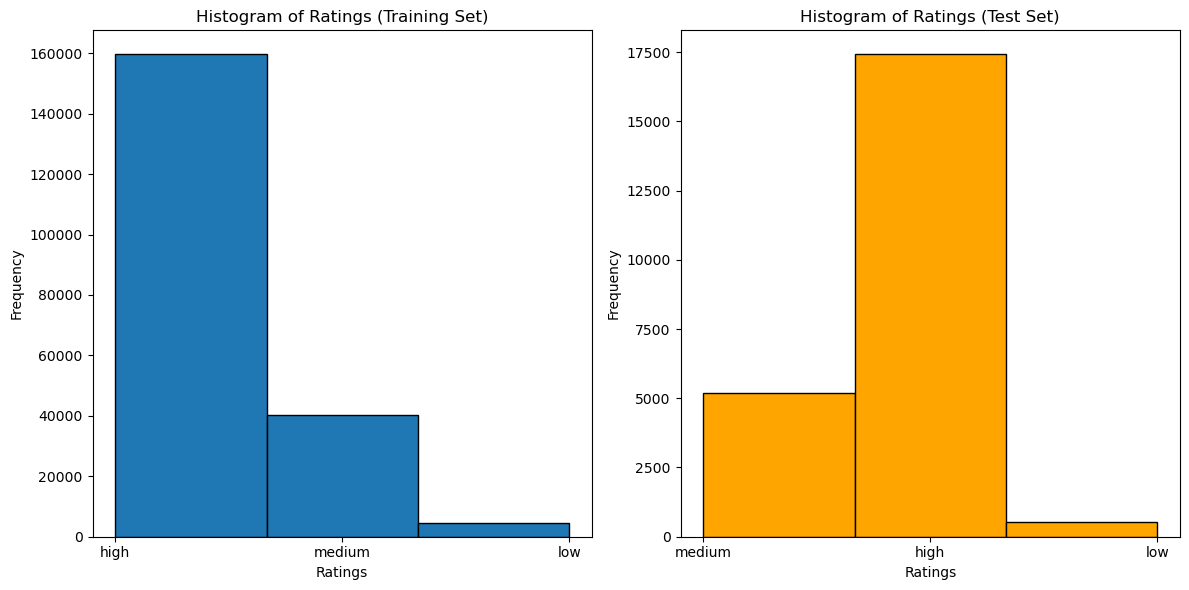

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# For Rating
axs[0].hist(merged_df["Book-Rating"], bins=10, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Book-Rating"], bins=10, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

# For Rating category
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(merged_df["Rating_Category"], bins=3, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Rating_Category"], bins=3, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

## BOW vectors for books' name

In [11]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

book_names = set(merged_df["Book-Title"])

# Preprocessing and tokenization
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and duplicates
    tokens = set([word for word in tokens if word not in stopwords.words('english')])
    return " ".join(tokens)

# Preprocess book names
preprocessed_books = [preprocess_text(book) for book in book_names]

# Creating bag-of-words vectors
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(preprocessed_books)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/skylarhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skylarhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


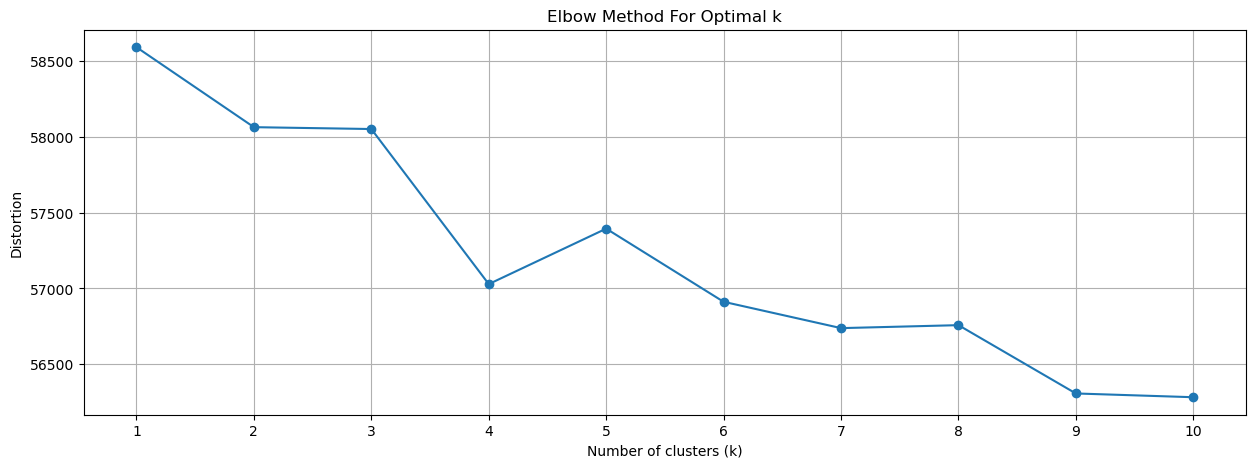

In [39]:
# Calculate distortion for a range of number of cluster
distortions = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bow_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(15, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [84]:
# Perform K-means clustering
num_clusters = 42  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(bow_matrix)

# Get cluster labels and assign each book to a cluster
cluster_labels = kmeans.labels_
book_clusters = {}
for i, book in enumerate(book_names):
    cluster = cluster_labels[i]
    if cluster not in book_clusters:
        book_clusters[cluster] = []
    book_clusters[cluster].append(book)

cluster_no_order = []
# Print out the clusters
for cluster, books in book_clusters.items():
    cluster_no_order.append(cluster + 1)
    print(f"Cluster {cluster + 1}:")
    print(len(books))
    '''for book in books:
        print(f"- {book}")'''

# If you are a user, you can input the book's name which you like, 
# it will output a cluster of books which are similar to what you like
def recomend_book_cluster(book_name):
    book_name = str(book_name).lower()
    for cluster_num, books in book_clusters.items():
        if book_name in books:
            return cluster_num
    return -1

# Extract highly rated books
highly_rated_book_clusters = {}

for cluster, books in book_clusters.items():
    highly_rated_books = []
    for book in books:
        book_info = books_rating_df[
            (books_rating_df["Book-Title"] == book)
            & (books_rating_df["Rating_Category"] == "high")
        ]
        if not book_info.empty:
            highly_rated_books.append(book)
    if highly_rated_books:
        highly_rated_book_clusters[cluster] = highly_rated_books

# Print the results
for cluster, books in highly_rated_book_clusters.items():
    print(f"Cluster {cluster + 1} (Highly Rated Books):", len(books))
    print(books)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 38:
803
Cluster 6:
10762
Cluster 33:
324
Cluster 24:
245
Cluster 2:
25
Cluster 25:
90
Cluster 5:
154
Cluster 27:
36
Cluster 15:
138
Cluster 17:
361
Cluster 20:
629
Cluster 29:
241
Cluster 41:
81
Cluster 10:
117
Cluster 1:
116
Cluster 42:
142
Cluster 31:
82
Cluster 23:
100
Cluster 19:
143
Cluster 34:
138
Cluster 13:
32
Cluster 40:
17
Cluster 32:
23
Cluster 4:
39
Cluster 39:
25
Cluster 35:
45
Cluster 9:
282
Cluster 7:
83
Cluster 11:
93
Cluster 12:
46
Cluster 18:
63
Cluster 16:
43
Cluster 21:
34
Cluster 30:
111
Cluster 28:
24
Cluster 37:
7
Cluster 22:
38
Cluster 36:
55
Cluster 26:
77
Cluster 8:
51
Cluster 14:
52
Cluster 3:
9
Cluster 38 (Highly Rated Books): 624
['star wars: from the adventures of luke skywalker : a novel', 'london : the novel', 'the wasp factory: a novel', 'the weight of water : a novel tag: author of resistance and strange fits of passion', 'the night listener : a novel', 'kiss of the night (a dark-hunter novel)', 'eat cake : a novel', 'the falls: an inspector re

In [88]:
from sklearn.metrics import pairwise_distances

# Compute centroids of clusters
cluster_centroids = kmeans.cluster_centers_

# Compute pairwise distances between centroids
distances = pairwise_distances(cluster_centroids)

# Print out distances between clusters
print("Distances between clusters:")
for i in range(num_clusters):
    cluster = cluster_no_order[i]
    for j in range(i+1, num_clusters):
        other_cluster = cluster_no_order[j]
        print(f"Cluster {cluster} to Cluster {other_cluster}: {distances[i][j]}")


Distances between clusters:
Cluster 38 to Cluster 6: 2.616880693878281
Cluster 38 to Cluster 33: 1.8403449416521023
Cluster 38 to Cluster 24: 1.492393104812451
Cluster 38 to Cluster 2: 1.4782313435078103
Cluster 38 to Cluster 25: 1.0565921105600686
Cluster 38 to Cluster 5: 1.4826227935061504
Cluster 38 to Cluster 27: 1.5326169624490342
Cluster 38 to Cluster 15: 1.4686972141822556
Cluster 38 to Cluster 17: 1.5223150159484984
Cluster 38 to Cluster 20: 1.4801851308282024
Cluster 38 to Cluster 29: 2.160076260445845
Cluster 38 to Cluster 41: 2.0748625103082206
Cluster 38 to Cluster 10: 1.4821275342342766
Cluster 38 to Cluster 1: 1.4821752061825715
Cluster 38 to Cluster 42: 1.5522942777455995
Cluster 38 to Cluster 31: 1.6134006961000695
Cluster 38 to Cluster 23: 1.4790864085448672
Cluster 38 to Cluster 19: 1.362812107171665
Cluster 38 to Cluster 34: 1.4675914435377044
Cluster 38 to Cluster 13: 1.33596958760417
Cluster 38 to Cluster 40: 1.3038461492496405
Cluster 38 to Cluster 32: 1.474604241

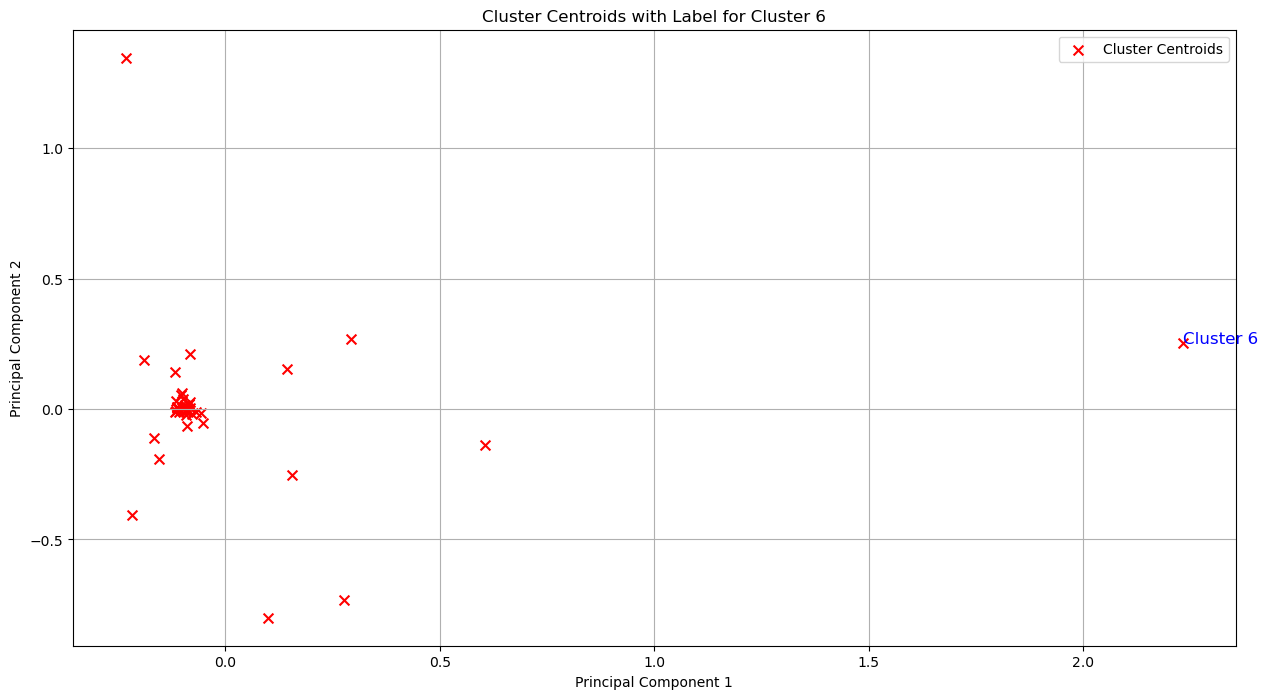

In [86]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality of centroids using PCA
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(cluster_centroids)

# Plot the centroids
plt.figure(figsize=(15, 8))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='x', color='red', label='Cluster Centroids', s=50)

# Annotate the centroid corresponding to cluster 6
cluster_6_index = cluster_no_order.index(6)  # Index of cluster 6 in the centroids array
plt.annotate('Cluster 6', (centroids_2d[cluster_6_index, 0], centroids_2d[cluster_6_index, 1]), fontsize=12, color='blue')

plt.title('Cluster Centroids with Label for Cluster 6')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
